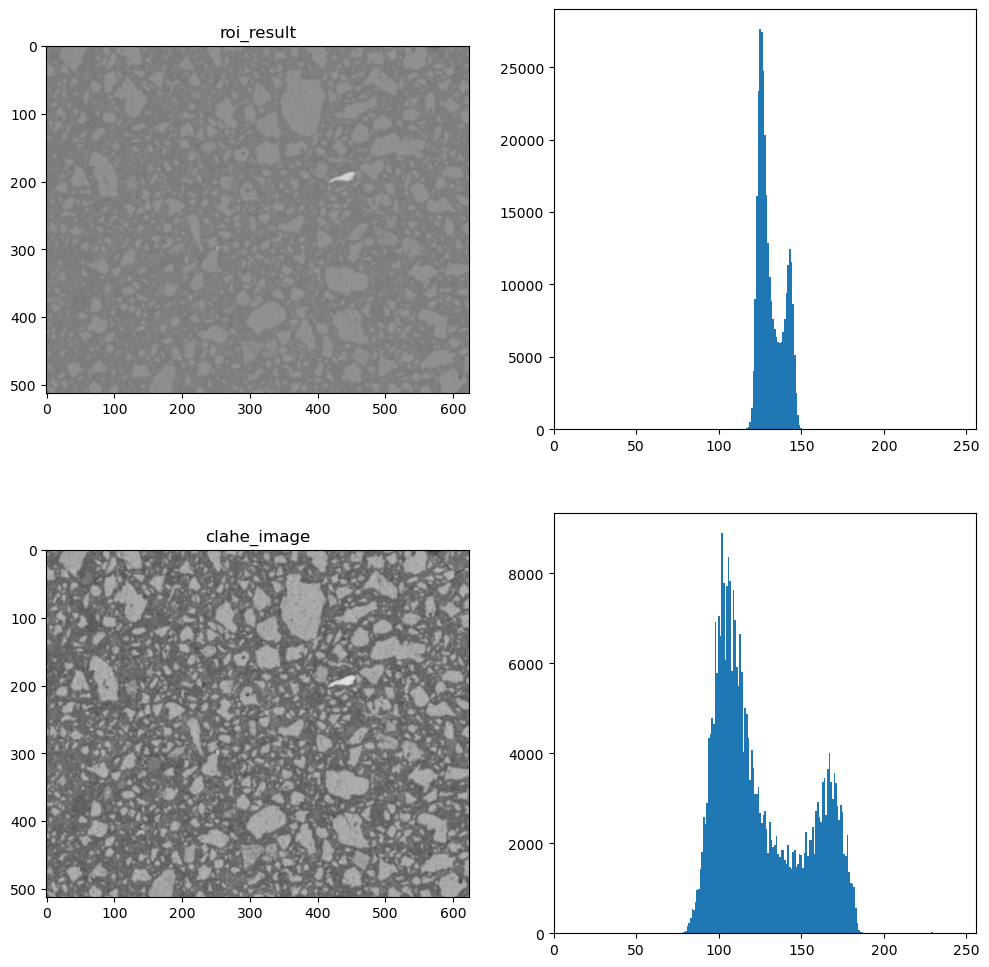

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 
from image_enhanced.image_preprocess import ImageProcess
from utils.tools import Tools
from utils.visualize import VisualizeData


config = Tools.load_yaml_config("preprocess_config.yaml")
img_process = ImageProcess(config)
# img_process.crop_enhaned_bse()
# bse图像处理
img_process.matched_bse_img_processed()
# ct图像处理
# img_process.matched_ct_img_processed()
# 寻找MI值最大的区域
# best_slice, patches_mi = img_process.choose_best_slices_bse_roi()

# path_pref = f"{img_process.bse_save_path}/{img_process.file_name_pref}"
# roi_enhanced_save_path = f'{path_pref}-enhanced-roi.bmp'
# masked_save_path = f'{path_pref}-masked.bmp'

# roi_enhanced_img = cv2.imread(roi_enhanced_save_path, cv2.IMREAD_GRAYSCALE)
# masked_img = cv2.imread(masked_save_path, cv2.IMREAD_GRAYSCALE)

# # 走错了，应该是直接剪切
# cropped_bse, cropped_masked, mask_with_bse = img_process.crop_processed_bse_bin_images(
#     roi_enhanced_img, masked_img, 
#     [config.start_left, config.start_top],
#     [config.cropped_width, config.cropped_height],
#     [config.offset_x, config.offset_y],
#     f"-{config.offset_x}-{config.offset_y}")

# # 展示四张图象
# rows, colums = 2, 2
# plt.figure(figsize=(8, 8))
# plt.subplot(rows, colums, 1), plt.imshow(roi_enhanced_img, cmap='gray',vmin=0, vmax=255), plt.title('roi_enhanced_img')
# plt.subplot(rows, colums, 2), plt.imshow(cropped_bse, cmap='gray',vmin=0, vmax=255), plt.title('cropped_bse')
# plt.subplot(rows, colums, 3), plt.imshow(cropped_masked, cmap='gray',vmin=0, vmax=255), plt.title('cropped_masked')
# plt.subplot(rows, colums, 4), plt.imshow(mask_with_bse, cmap='gray',vmin=0, vmax=255), plt.title('mask_with_bse')
# h = Tools.caculate_entropy(Tools.downsample_image(np.array(cropped_masked), 2))
# print(f"masked_h: {h}")


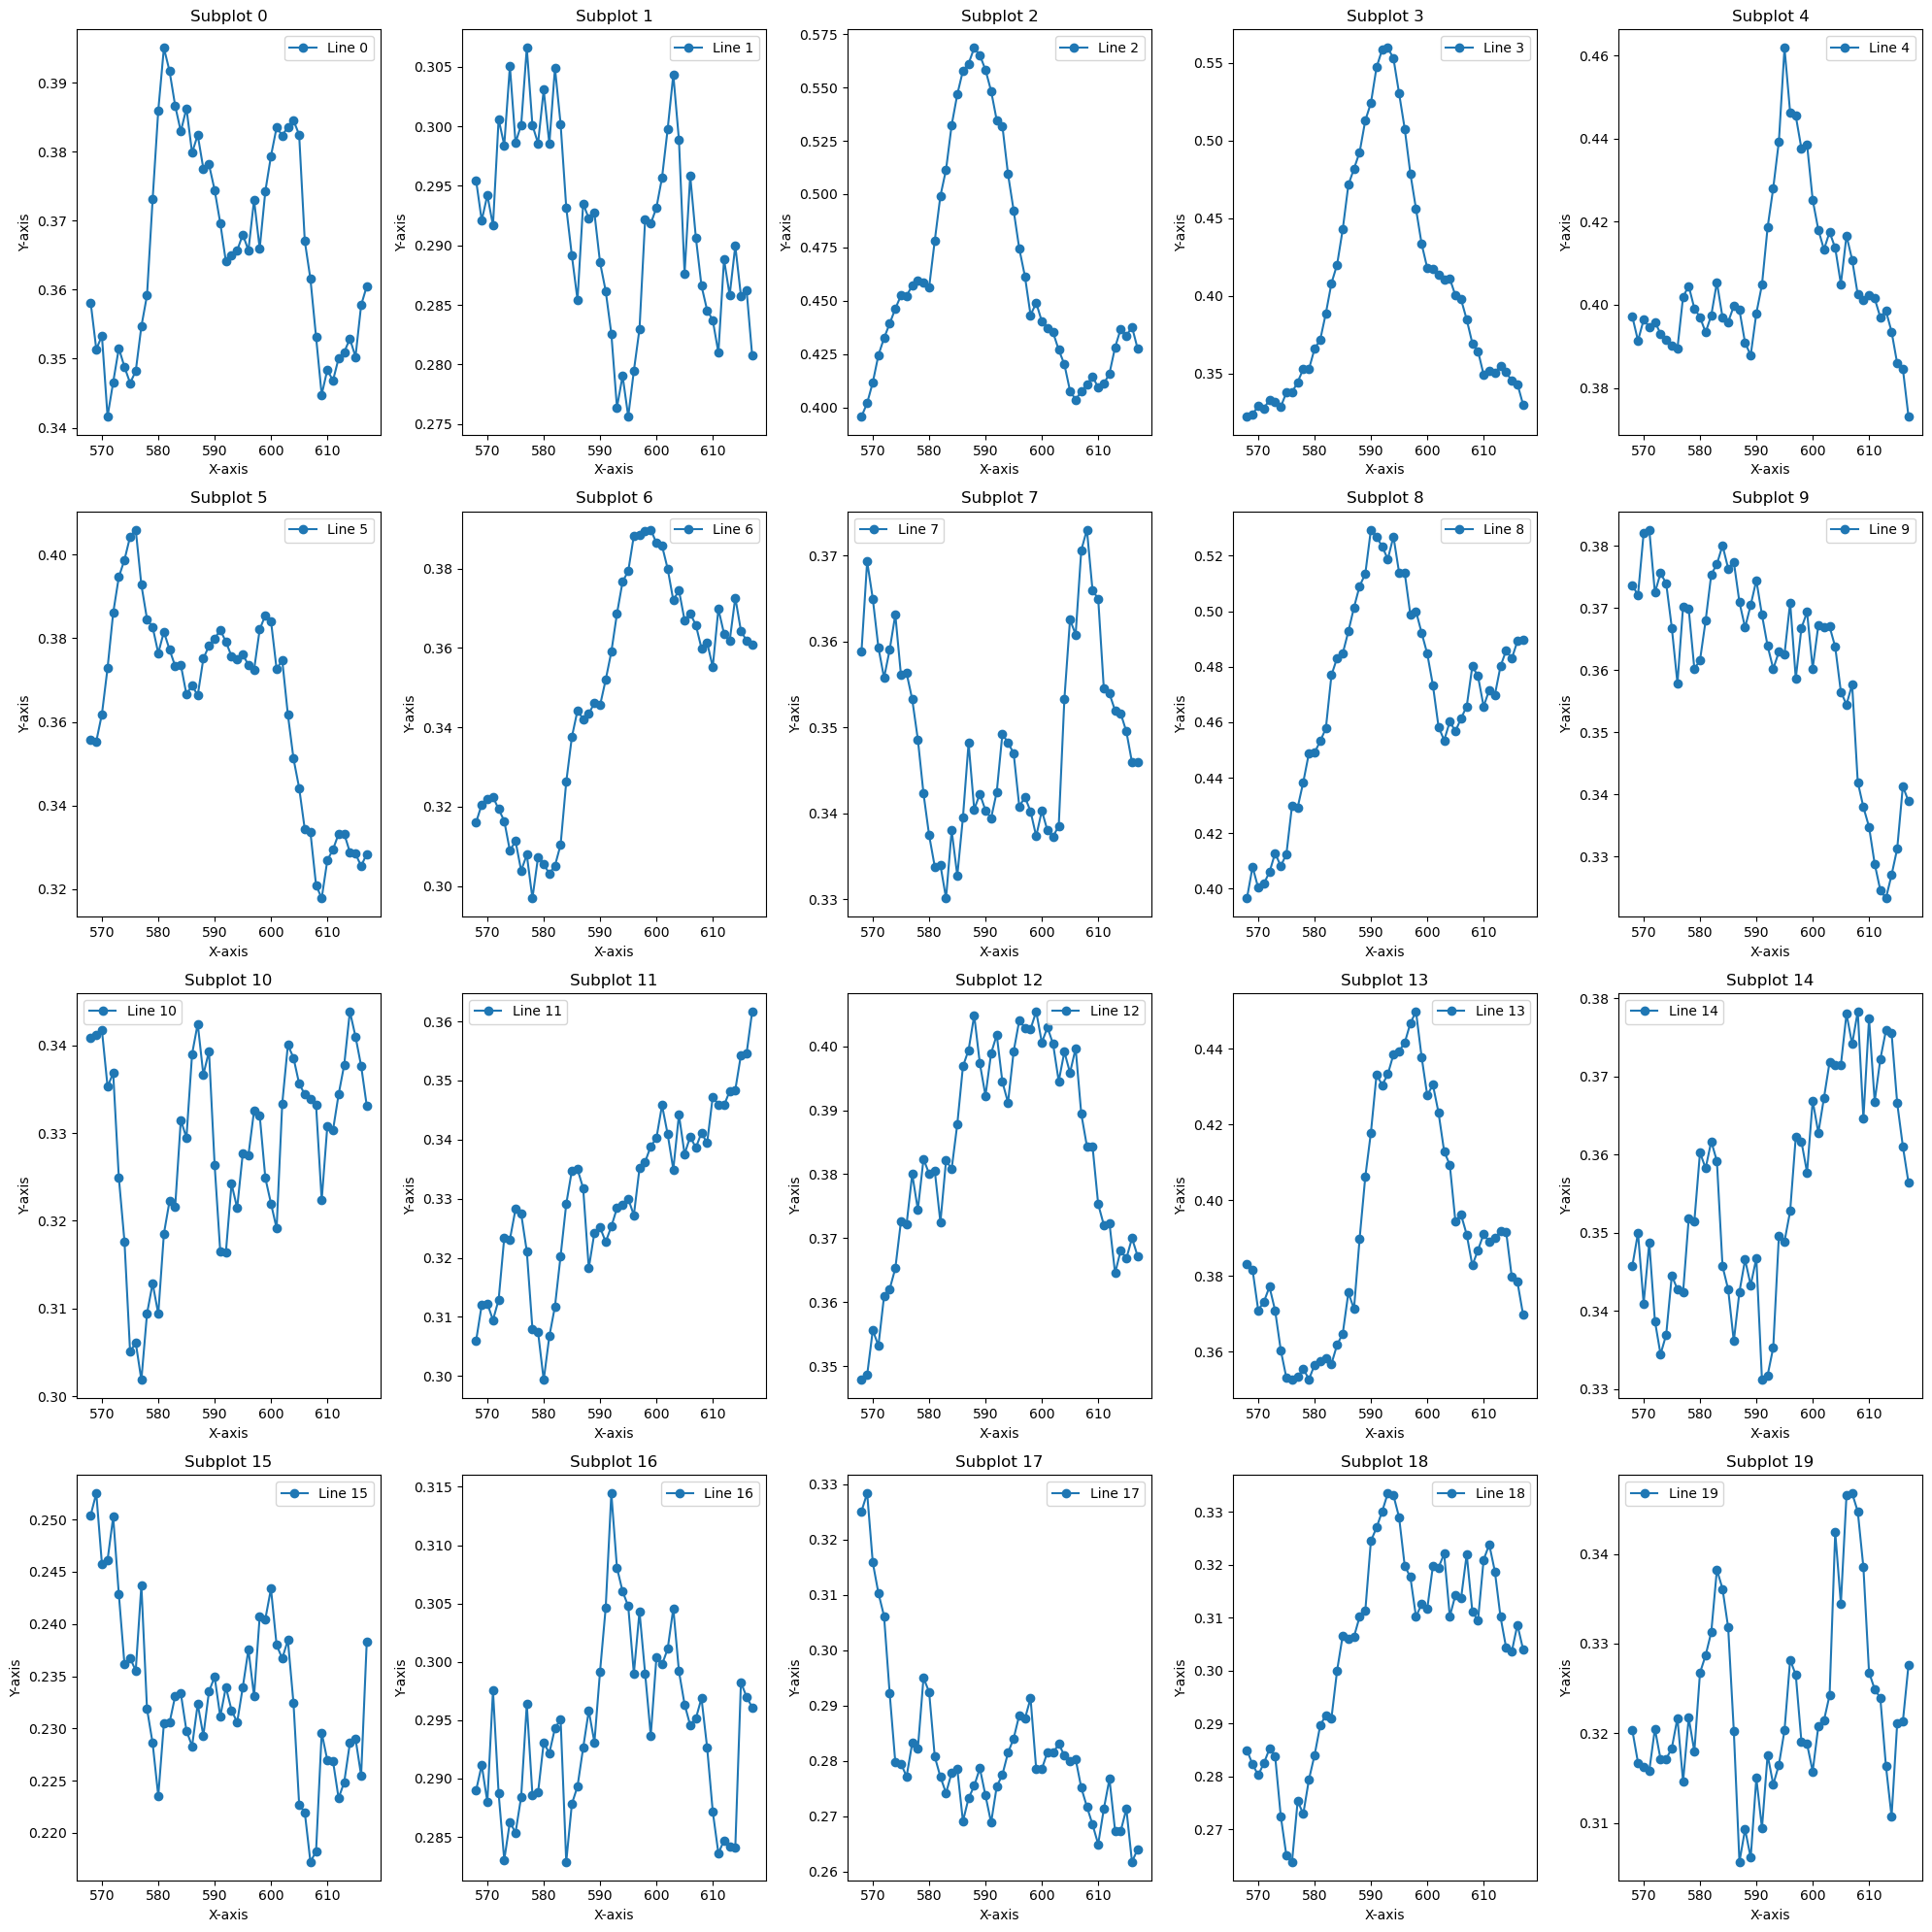

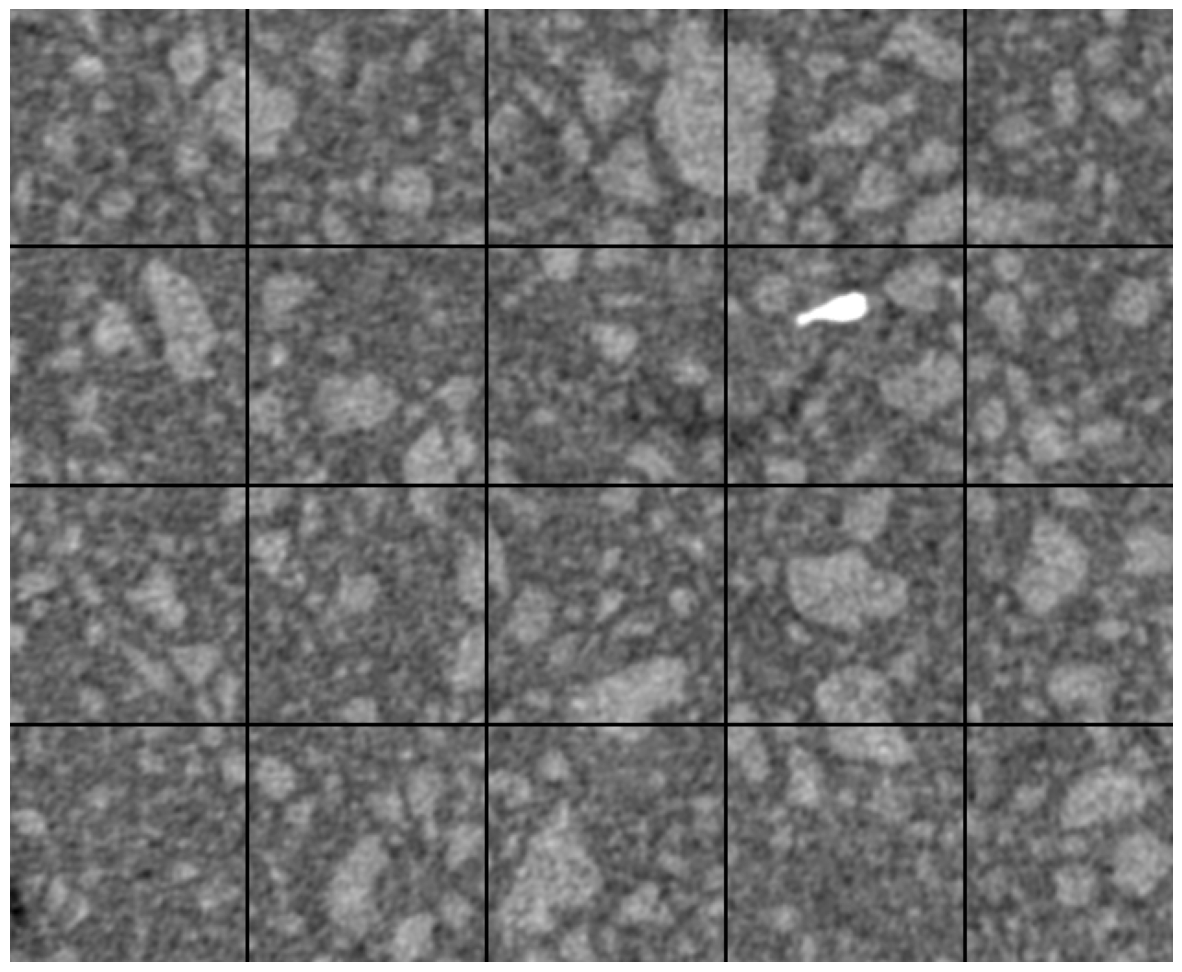

In [28]:
import copy
# 这里面的数据已经被打乱了...所以用深克隆
imgs = []

def construct_patch_mi_line_chart(patch_mi):
    x = []
    y = []
    items = patch_mi.get("mis")
    for slice_mi_item in items:
        x.append(slice_mi_item.get("slice_index").item())
        y.append(slice_mi_item.get("mi").item())

    return x, y

xs = []
ys = []

for patch_mi in patches_mi:
    mi_info = patch_mi.get("mis")
    x, y = construct_patch_mi_line_chart(patch_mi)
    xs.append(x)
    ys.append(y)

for patch_mi in patches_mi:
    mi_info = patch_mi.get("mis")
    infos = copy.deepcopy(mi_info)
    # 这里不用怎么排序的，因为之后还要显示这几个MI的变化情况
    infos.sort(key=lambda p: p.get("mi"))
    imgs.append(infos[-1].get("cropped_img"))

cols, rows = 5, 4

# 创建一个包含3个子图的图形
fig, axs = plt.subplots(rows, cols, figsize=(20, 20))

count = 0
for i in range(rows):
    for j in range(cols):
        # 绘制第一个子图
        axs[i][j].plot(xs[count], ys[count], label=f'Line {count}', marker='o')
        axs[i][j].set_title(f'Subplot {count}')
        axs[i][j].set_xlabel('X-axis')
        axs[i][j].set_ylabel('Y-axis')
        axs[i][j].legend()
        count+=1
# 自动调整子图之间的间距
plt.tight_layout()
# 显示图表
plt.show()

VisualizeData.concate_imgs_show(imgs, 5, 2)

In [3]:
# 先把ct_数组先加载起来再说
# 加载ct数据np数组，shape为[depth, width, height]，暂时加载个样本4-S1的数组，加载100张，从535到635
def load_ct_np():
    path = "G:/CT/4/Reconstruction/4-_IR_rec00000"
    start_id = 535
    num = 100

    ct_img = None
    for add_delta in range(num):
        id = start_id + add_delta
        slice_path = f"{path}{id}.bmp"
        slice_img = cv2.imread(slice_path, cv2.IMREAD_GRAYSCALE)
        slice_img = slice_img.reshape(1, 1920, 1920)

        if ct_img is None : ct_img = slice_img
        else: ct_img = np.concatenate([ct_img, slice_img], axis=0)
    
    return ct_img


volume = load_ct_np()

In [6]:
import numpy as np

r = np.array([[1, 2, 3], 
              [4, 5, 6],
              [4, 5, 6]])

print(r.shape)
r = r[np.newaxis, :]
print(r.shape)

(3, 3)
(1, 3, 3)


theta_width: 3.6753263867612644, theta_height: 4.480798785982208
rotation center: [403.58394418 403.58394418  54.        ]
origin: [3.45019118e-01 4.20268348e+02 5.40000000e+01]
x+1 from origin: [  0.94683414 419.46971202  54.        ]
y+1 from origin: [  1.14365463 420.87016255  54.        ]
[  0 420  54]
0


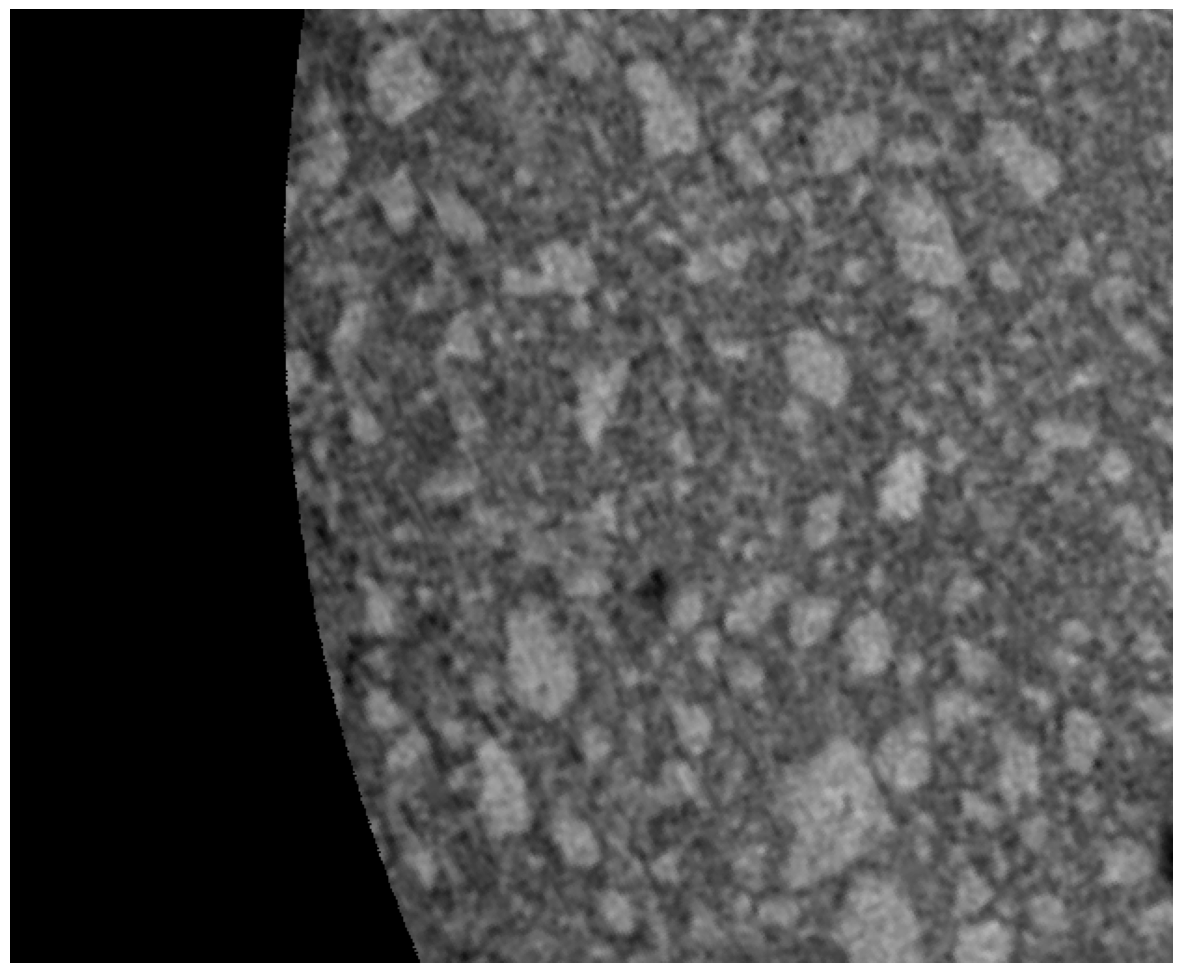

In [107]:
import math
from scipy.interpolate import interpn

import numpy as np

def trilinear_interpolation(ct_image, index_array):
    """
    手动实现三线性插值。
    
    参数:
    ct_image -- 三维CT图像，形状为 (depth, height, width)
    index_array -- 插值点的索引数组，形状为 (width, height, 3)
    
    返回:
    values -- 插值后的值，形状为 (width, height)
    """
    def get_value_at_point(ct_image, z, y, x):
        depth, height, width = ct_image.shape
        
        # 获取八个顶点的坐标
        x0, x1 = int(np.floor(x)), int(np.ceil(x))
        y0, y1 = int(np.floor(y)), int(np.ceil(y))
        z0, z1 = int(np.floor(z)), int(np.ceil(z))
        
        # 确保坐标不越界
        x0, x1 = max(0, x0), min(width - 1, x1)
        y0, y1 = max(0, y0), min(height - 1, y1)
        z0, z1 = max(0, z0), min(depth - 1, z1)
        
        # 获取八个顶点的值
        c000 = ct_image[z0, y0, x0]
        c001 = ct_image[z0, y0, x1]
        c010 = ct_image[z0, y1, x0]
        c011 = ct_image[z0, y1, x1]
        c100 = ct_image[z1, y0, x0]
        c101 = ct_image[z1, y0, x1]
        c110 = ct_image[z1, y1, x0]
        c111 = ct_image[z1, y1, x1]
        
        # 计算插值系数
        xd = (x - x0) / (x1 - x0) if x1 != x0 else 0
        yd = (y - y0) / (y1 - y0) if y1 != y0 else 0
        zd = (z - z0) / (z1 - z0) if z1 != z0 else 0
        
        # 线性插值
        c00 = c000 * (1 - xd) + c001 * xd
        c01 = c010 * (1 - xd) + c011 * xd
        c10 = c100 * (1 - xd) + c101 * xd
        c11 = c110 * (1 - xd) + c111 * xd
        
        c0 = c00 * (1 - yd) + c01 * yd
        c1 = c10 * (1 - yd) + c11 * yd
        
        c = c0 * (1 - zd) + c1 * zd
        
        return c
    
    width, height = index_array.shape[:2]
    values = np.zeros((width, height))
    
    for i in range(width):
        for j in range(height):
            y, x, z = index_array[i, j]
            values[i, j] = get_value_at_point(ct_image, z, y, x)
    
    return np.clip(values, 0, 255)  # 确保值在0-255范围内


def rotation_matrix_from_euler_angles(angles, order='XYZ'):
    """
    根据欧拉角生成旋转矩阵。
    参数：
    angles -- 欧拉角，长度为 3 的数组，表示绕每个轴的旋转角度
    order -- 旋转顺序，默认为 'XYZ'
    返回：
    rotation_matrix -- 旋转矩阵，形状为 (3, 3)
    """
    theta_x, theta_y, theta_z = angles
    
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theta_x), -np.sin(theta_x)],
        [0, np.sin(theta_x), np.cos(theta_x)]
    ])
    
    Ry = np.array([
        [np.cos(theta_y), 0, np.sin(theta_y)],
        [0, 1, 0],
        [-np.sin(theta_y), 0, np.cos(theta_y)]
    ])
    
    Rz = np.array([
        [np.cos(theta_z), -np.sin(theta_z), 0],
        [np.sin(theta_z), np.cos(theta_z), 0],
        [0, 0, 1]
    ])
    
    if order == 'XYZ':
        return np.dot(Rz, np.dot(Ry, Rx))
    elif order == 'ZYX':
        return np.dot(Rx, np.dot(Ry, Rz))
    else:
        raise ValueError("Unsupported rotation order")

# rotation_center：就是切片的中心对应的那个点
# points: 切片
# rotations: (rotation_x, rotation_y, rotation_z)都是角度
def rotate_points(rotation_center, rotations, points):
    # 定义旋转角度（弧度制）
    theta_x = np.radians(rotations[0])  # 绕 x 轴旋转角度
    theta_y = np.radians(rotations[1])  # 绕 y 轴旋转角度
    theta_z = np.radians(rotations[2])  # 绕 z 轴旋转角度

    # 根据欧拉角生成旋转矩阵，固定旋转顺序为 'XYZ'
    rotation_matrix = rotation_matrix_from_euler_angles([theta_x, theta_y, theta_z], order='XYZ')

    translate_2_origin = np.array(rotation_center)

    points_in_origin = points - translate_2_origin
    points_after_rotate = np.dot(points_in_origin, rotation_matrix)

    points_after_transform = points_after_rotate + translate_2_origin

    # 注意这个地方跑出了边界外的处理，需要进行限制，两个方面限制
    # （1）确实就是超出去了怎么办，其中有负值，那么怎么处理，这个地方设置不当容易造成溢出
    # （2）可以事先进行先验的范围设置
    # 这个地方不能直接这样暴力地转换，要进行四舍五入的处理

    if points_after_transform.min() < 0 : raise ValueError("索引小于零，访问越界！")

    return points_after_transform

# 对点进行位移，translation：(translation_x, translation_y, translation_z)
def translate_points(translation, points):
    # 注意这个地方的point具体的坐标是[rows, cols, dim]，而对于我们的translation数组，
    # 它应该是[width_delta, height_delta, z_delta]，因此需要转换
    translation[0], translation[1] = translation[1], translation[0]

    translation = np.array(translation)
    # 需要在这个地方进行判定不，不能为负，为负就跳出异常
    after_translate = points + translation
    if after_translate.min() < 0 : raise ValueError("索引小于零，访问越界！")
    return after_translate

def force_convert_uint(index_array):
    index_array = np.round(index_array)
    index_array = index_array.astype(np.uint16)
    return index_array

# 计算距离切片的偏移, size:[width, height]
def compute_offset_from_ct(ct_size, slice_size):
    delta_x = ct_size[0] * .5 - slice_size[0] * .5
    delta_y = ct_size[1] * .5 - slice_size[1] * .5
    return [delta_x, delta_y]

# 从索引中插值
def interlopation_ct_from_indeces(ct_img, index_array):
    # 定义网格点的坐标
    depth, height, width = ct_img.shape
    grid_z, grid_y, grid_x = np.arange(depth), np.arange(height), np.arange(width)
    grid = (grid_z, grid_y, grid_x)

    ct_img = ct_img.astype(np.float32)

    # 使用三线性插值
    values = interpn(grid, ct_img, index_array, method='linear', bounds_error=False, fill_value=None)
    return values


volume_shape = volume.shape

depth, height, width  =  volume_shape # (depth, rows, cols)
slice_width, slice_height = 624, 512

delta = compute_offset_from_ct([width, height], [slice_width, slice_height])
slice_idx = 54

# 使用 meshgrid 生成网格，然后将其转换为所需格式
x, y = np.meshgrid(np.arange(slice_height), np.arange(slice_width))
# 转置网格坐标，使其符合 [N, M] 的形状
x = x.T
y = y.T
# 堆叠坐标网格形成所需的数组
coordinates = np.stack((x, y), axis=-1)
# 创建一个与 coordinates 形状匹配的常量数组
constant_array = np.full(coordinates.shape[:-1] + (1,), slice_idx)
coordinates = coordinates + delta

# 将 coordinates 和 constant_array 连接起来
index_array = np.concatenate((coordinates, constant_array), axis=-1)

latent_depth = 20
sin_theta_width = latent_depth / (slice_width * 0.5)
sin_theta_height = latent_depth / (slice_height * 0.5)
radians_height = math.asin(sin_theta_height)
degree_height = math.degrees(radians_height)
radians_width = math.asin(sin_theta_width)
degree_width = math.degrees(radians_width)
print(f"theta_width: {degree_width}, theta_height: {degree_height}")

# bse切面外接圆半径
r_slice_circle = math.sqrt(slice_width**2 + slice_height**2) * 0.5
max_width_delta = r_slice_circle - slice_width * 0.5
max_height_delta = r_slice_circle - slice_height * 0.5
# 那么如何限定范围呢，对就是这样！
delta_x = max_width_delta #+1
delta_y = max_height_delta #+1

translation = [-delta[1] + delta_x, -delta[0] + delta_y, 0] # 
# slice_idx为54的话 正好达到边界 26 degree_width, degree_height

index_array = translate_points(translation, index_array)
# 这个index_array的坐标是rows, cols，对应的图像上应该是height， width
rotation_center = index_array[slice_height // 2, slice_width // 2]
print(f"rotation center: {rotation_center}")
index_array = rotate_points(rotation_center, [0, 0, 53], index_array)

print("origin:", index_array[0, 0])
print("x+1 from origin:", index_array[1, 0]) # 应该是x增，但是现在是y增
print("y+1 from origin:", index_array[0, 1]) # 应该是y增，但是现在是x增

integer_indeces = force_convert_uint(index_array)
# 通过index_array来进行索引切片
result = volume[integer_indeces[..., 2], integer_indeces[..., 0], integer_indeces[..., 1]]

# 通过插值的方法得到结果
# result_interpolation = trilinear_interpolation(volume, index_array) #interlopation_ct_from_indeces(volume, self_index)
origin = index_array[0, 0].astype(np.uint16)
print(origin)
gray = volume[origin[2], origin[0], origin[1]]
print(gray)


VisualizeData.show_image(result)
# VisualizeData.show_image(result_interpolation)


In [5]:
import cv2, os
from utils.tools import Tools
from utils.visualize import VisualizeData
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'

downsamples = 2

mv_path = "D:/workspace/ml-workspace/registration/datasets/sample4/ct/matched/cropped_ct_585_1024.bmp"
fx_path = "D:/workspace/ml-workspace/registration/datasets/sample4/bse/s1/100/4-1-1-matched-bse-0-0.bmp"
ms_path = "D:/workspace/ml-workspace/registration/datasets/sample4/bse/s1/100/4-1-1-matched-masked-0-0.bmp"

# img = cv2.imread(mv_path, cv2.IMREAD_GRAYSCALE)

# img2 = Tools.crop_rotate(img, (0, 0), (256, 256), 0)
# plt.figure(figsize=(12, 8))
# plt.subplot(2, 2, 1), plt.imshow(img2, cmap='gray'), plt.title('refer')
# # Load the images
moving_img = Tools.downsample_image(cv2.imread(mv_path, cv2.IMREAD_GRAYSCALE), downsamples)
fixed_img = Tools.downsample_image(cv2.imread(fx_path, cv2.IMREAD_GRAYSCALE), downsamples)
masked_img = Tools.downsample_image(cv2.imread(ms_path, cv2.IMREAD_GRAYSCALE), downsamples)

visualize = VisualizeData(moving_img, fixed_img, masked_img)
visualize.spawn_datas([384, 384], 10, "visualize_0_0")

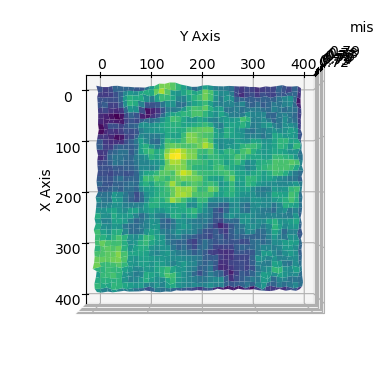

In [13]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
# mis, mis_masked
visualize.show_datas("mis", 0, 90)

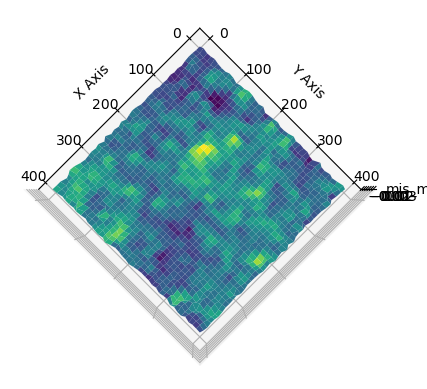

In [11]:
visualize.show_datas("mis_masked", 45, 90)